In [572]:
### ref: HACT_Numerical_Appendix section 5
import copy
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve, LinearOperator, gmres
from scipy.linalg import norm
from scipy.sparse import diags
#from scipy import spsolve
# import jax
# import jax.numpy as np
import scipy.sparse
# import scipy.sparse.linalg
# from jax import config
# config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

In [573]:
s = 2
r = 0.03
rho = 0.05
Var = 0.07
sig2 = (0.1)**2
w=1.03
amin = -1     # borrowing constraint
amax = 30     # range a
I = 100       # number of a points 

a = np.linspace(amin,amax,I).reshape((I,1))
da = (amax-amin)/(I-1)

zmin = 0.5    # Range z
zmax = 1.5
J = 40
z = np.linspace(zmin,zmax,J).reshape((J,1))
dz = (zmax-zmin)/(J-1)
dz2 = dz**2


zmean = 1.0
Corr = np.exp(-0.3)
the = -np.log(Corr)
Var = sig2/(2*the)
sig2 = 2*the*Var


aa = a * np.ones((I, J))
zz = np.ones((I, J)) * z.T

mu = the*(zmean - z).reshape((1,J))
s2 = sig2*np.ones((1,J))


dt = 0.01

In [574]:
def computechi():
    return (-np.minimum(mu,0)/dz + s2/(2*dz2)).reshape((J,1))

In [575]:
def computeyy():
    return (np.minimum(mu,0)/dz - np.maximum(mu,0)/dz - s2/dz2).reshape((J,1))

In [576]:
def computezeta():
    return (np.maximum(mu,0)/dz + s2/(2*dz2)).reshape((J,1))

In [577]:
def constructC():
    zeta = computezeta()
    chi = computechi()
    yy = computeyy()
    updiag = np.zeros((I,1))
    for j in range(J):
        updiag = np.vstack((updiag, np.tile(zeta[j], (I,1))))
    centdiag = np.tile(chi[0]+yy[0],(I,1))
    for j in range(1,J-1):
        centdiag = np.vstack((centdiag, np.tile(yy[j], (I,1))))
    centdiag = np.vstack((centdiag, np.tile(yy[J-1]+zeta[J-1], (I,1))))

    # This will be the lower diagonal of the B_switch
    lowdiag = np.tile(chi[1], (I,1))
    for j in range(2,J):
        lowdiag = np.vstack((lowdiag, np.tile(chi[j], (I,1))))

    # Add up the upper, center, and lower diagonal into a sparse matrix   page 18 matrix C
    Cswitch = scipy.sparse.spdiags(centdiag[:,0], 0, I*J, I*J)\
            + scipy.sparse.spdiags(lowdiag[:,0], -I, I*J, I*J)\
            + scipy.sparse.spdiags(updiag[:,0], I, I*J, I*J)
    return Cswitch

In [578]:
def computeVaf(V):
    Vaf = (V[1:I,:]-V[0:I-1,:])/da
    re = (w*z + r*amax)**(-s)
    Vaf = np.vstack([Vaf,re.reshape((40,))])
    return Vaf

In [579]:
def computeVab(V):    
    Vab = (V[1:I,:]-V[0:I-1,:])/da
    re = (w*z + r*amin)**(-s) 
    Vab = np.vstack([re.reshape((40,)),Vab])
    return Vab

In [644]:
def computecf(Vaf):
    return Vaf**(-1/s)

In [645]:
def computesf(cf,r):
    return w*zz + r*aa - cf

In [646]:
def computecb(Vab):
    return Vab**(-1/s)

In [647]:
def computesb(cb,r):
    return w*zz + r*aa - cb

In [648]:
def computec(Vaf,Vab,sf,sb,r):
    # sf = computesf(cf)
    # sb = computesb(cb)
    c0 = zz + r*aa
    Va0 = c0**(-s)
    If = np.where(sf>0, 1, 0)
    Ib = np.where(sb<0, 1, 0)
    I0 = (1-If-Ib)
    Va_Upwind = Vaf*If + Vab*Ib + Va0*I0
    c = Va_Upwind**(-1/s)
    return c

In [649]:
def computeu(c):
    return c**(1-s)/(1-s)

In [650]:
def constructA(sf,sb):
    # sf = computesf(Vaf)
    # sb = computesb(Vab)
    X = -np.minimum(sb,0)/da   
    Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
    Z = np.maximum(sf,0)/da
    Z = Z.reshape(-1,order='F')
    A_up = scipy.sparse.spdiags(np.concatenate([np.array([0]),Z]),1,I*J,I*J)
    Y = Y.reshape(-1,order='F')
    A_diag = scipy.sparse.spdiags(Y, 0, I*J, I*J)
    X = X.reshape(-1,order='F')
    X = np.roll(X, -1)
    A_down = scipy.sparse.spdiags(X, -1, I*J, I*J)
    AA = A_down + A_diag + A_up
    Cswitch = constructC()
    A = AA + Cswitch
    return A

In [651]:
def SolveLinHJB(sf,sb,c):
    A = constructA(sf,sb)
    B = (rho)*scipy.sparse.eye(I*J) - A
    u = computeu(c)
    u_stack = u.reshape(-1,order='F')
    v = scipy.sparse.linalg.spsolve(B,u_stack)
    return v

In [652]:
def SolveFPK(sf,sb):
    AT =  (constructA(sf,sb).T).todense()
    b = np.zeros((I*J,1))
    i_fix = 0
    b[i_fix] = 0.001
    row = np.concatenate((np.array([1]), np.zeros((I*J-1))))
    AT[i_fix,:] = row
    gg = scipy.sparse.linalg.spsolve(scipy.sparse.csr_matrix(AT), b)
    g_sum = gg@np.ones((I*J))*da*dz
    gg = gg/g_sum
    g = gg.reshape((I,J), order='F')
    return g

In [653]:
def updateK(g,K):
    relax=0.99
    # alpha = 0.35 # Production function F = K^alpha * L^(1-alpha) 
    # delta = 0.1 # Capital depreciation 
    S = np.sum(g.T@a*da*dz)
    # print('S:', S)
    # update prices
    return relax*K +(1-relax)*S           # relaxation algorithm (to ensure convergence)

In [654]:
def updater(K):
    relax=0.99
    alpha = 0.35 # Production function F = K^alpha * L^(1-alpha) 
    delta = 0.1 # Capital depreciation 
    # S = np.sum(g.T@a*da*dz)
    # # print('S:', S)
    # # update prices
    # K = relax*K +(1-relax)*S           # relaxation algorithm (to ensure convergence)
    # # r = alpha     * K**(alpha-1) -delta # interest rates
    return np.maximum(alpha* K**(alpha-1)-delta,0)
    # w = (1-alpha) * K**(alpha) 


In [655]:
#Intialize
# K=1
# r=0.05
# v = (zz + r*aa)**(1-s)/(1-s)/rho
# Vaf = computeVaf(v)
# Vab = computeVab(v)
# cf=computecf(Vaf)
# cb=computecb(Vab)
# sf=computesf(cf,r)
# sb=computesf(cb,r)
# # c=computec(Vaf,Vab,cf,cb)
# # u=computeu(c)

In [656]:
maxit  = 3    # maximum number of iterations in the HJB loop
maxitHJB = 500     # maximum number of iterations in the K loop
crit = 10**(-6)  # criterion HJB loop
critr = 10**(-5) # criterion K loop
K=2
r=0.04848
v0 = (w*zz + r*aa)**(1-s)/(1-s)/rho
v = copy.deepcopy(v0)
Vaf = computeVaf(v)
Vab = computeVab(v)
cf=computecf(Vaf)
cb=computecb(Vab)
sf=computesf(cf,r)
sb=computesf(cb,r)
c=computec(Vaf,Vab,sf,sb,r)
#def main(iteration):
for iter in range(maxit):
        #Solve FPK equation
    g=SolveFPK(sf,sb)
    K=updateK(g,K)
    r_new=updater(K)
    print('r:', r)
    if np.abs(r-r_new)<critr:
       break
    #r=r_new
    #r=0.995*r+0.005*r_new
    #r=(1-2/(iter+500))*r+(2/(iter+500))*r_new
    # sf=computesf(cf,r)
    # sb=computesf(cb,r)
    # c=computec(Vaf,Vab,sf,sb,r)
        # Solve linearized HJB equation
    sf=computesf(cf,r)
    sb=computesf(cb,r)
    c=computec(Vaf,Vab,sf,sb,r)
    for k in range(maxitHJB):
        v_new = SolveLinHJB(sf,sb,c)
        v_new = v_new.reshape((100,40), order='F')
        if np.max(np.abs(v-v_new)) < crit:
            print('Value Function Converged, Iteration = ', k)
            break
        v=v_new
        Vaf = computeVaf(v)
        Vab = computeVab(v)
        # print(Vaf)
        cf=computecf(Vaf)
        cb=computecb(Vab)
        sf=computesf(cf,r)
        sb=computesf(cb,r)
        c=computec(Vaf,Vab,sf,sb,r)
        # if np.max(np.abs(v-v_new)) < crit:
        #     print('Value Function Converged, Iteration = ', k)
        #     break
    # print('r:', r)
    # if np.abs(r-r_new)<critr:
    #    break
    # #return r,v


r: 0.04848


/var/folders/pd/7txl5xrn151dcbvtj90xy_h80000gn/T/ipykernel_16984/2469888282.py:2: RuntimeWarning: invalid value encountered in power
  return Vaf**(-1/s)
/var/folders/pd/7txl5xrn151dcbvtj90xy_h80000gn/T/ipykernel_16984/1705458590.py:6: MatrixRankWarning: Matrix is exactly singular
  v = scipy.sparse.linalg.spsolve(B,u_stack)


dgstrf info 3272
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgs

/var/folders/pd/7txl5xrn151dcbvtj90xy_h80000gn/T/ipykernel_16984/3836577531.py:8: MatrixRankWarning: Matrix is exactly singular
  gg = scipy.sparse.linalg.spsolve(scipy.sparse.csr_matrix(AT), b)


dgstrf info 7
r: 0.04848
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf info 2
dgstrf in

In [657]:
r_new

nan

In [658]:
g=SolveFPK(sf,sb)

dgstrf info 7


/var/folders/pd/7txl5xrn151dcbvtj90xy_h80000gn/T/ipykernel_16984/3836577531.py:8: MatrixRankWarning: Matrix is exactly singular
  gg = scipy.sparse.linalg.spsolve(scipy.sparse.csr_matrix(AT), b)


In [659]:
np.sum(g.T@a*da*dz)

nan

/var/folders/pd/7txl5xrn151dcbvtj90xy_h80000gn/T/ipykernel_16984/1193131614.py:5: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surface = ax.plot_surface(A_plot, Z_plot, g.T, cmap='viridis', rstride=5, cstride=5, alpha=1, antialiased=True)


Text(0.5, 0, 'z')

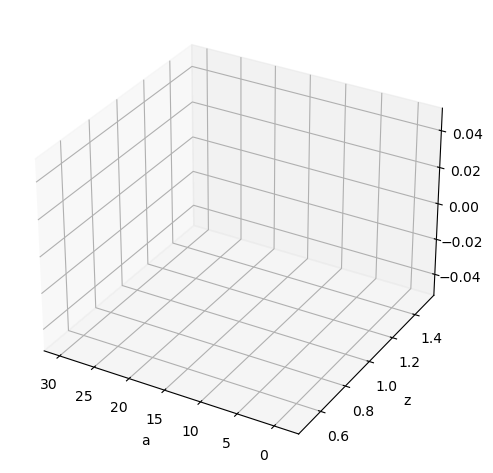

In [660]:
fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax = fig1.add_subplot(111, projection='3d')
A_plot,Z_plot = np.meshgrid(a, z)
ax.invert_xaxis()
surface = ax.plot_surface(A_plot, Z_plot, g.T, cmap='viridis', rstride=5, cstride=5, alpha=1, antialiased=True)
ax.set_xlabel('a')
ax.set_ylabel('z')

In [661]:
# r=0.048
# v_initial = (zz + r*aa)**(1-s)/(1-s)/rho
# v = (zz + r*aa)**(1-s)/(1-s)/rho
# for iter in range(100):
#     Vaf = computeVaf(v)
#     Vab = computeVab(v)
#     cf = computecf(Vaf)
#     cb = computecb(Vab)
#     sf = computesf(cf,r)
#     sb = computesb(cb,r)
#     c = computec(Vaf,Vab,sf,sb,r)
#     v_new = SolveLinHJB(sf,sb,c)
#     v_new = v_new.reshape((I,J), order='F')
#     v = v_new

In [662]:
result = main(iteration = 10)

NameError: name 'main' is not defined

In [ ]:
Vaf

NameError: name 'Vaf' is not defined

In [ ]:
result[0]

0.048

In [ ]:
v

array([[-22.90403406, -22.83101601, -22.72221018, ..., -19.55703304,
        -19.51071108, -19.48083509],
       [-22.27683059, -22.22264838, -22.14056902, ..., -19.301912  ,
        -19.25566712, -19.22599564],
       [-21.796606  , -21.75092154, -21.68127281, ..., -19.03806749,
        -18.99658926, -18.96989256],
       ...,
       [-10.12016361, -10.11431728, -10.10528746, ...,  -9.67164197,
         -9.66337002,  -9.65802366],
       [-10.0682693 , -10.06248473, -10.05355025, ...,  -9.62437145,
         -9.61618257,  -9.61088988],
       [-10.01692117, -10.01119734, -10.00235663, ...,  -9.57757265,
         -9.56946555,  -9.56422568]])

In [ ]:
r=0.048
# c0 = zz + r*aa
# Va0 = c0**(-s)
v = (zz + r*aa)**(1-s)/(1-s)/rho

In [ ]:
computeVaf(v)

array([[4.54765738, 4.07955058, 3.68017296, ..., 0.48409936, 0.46694003,
        0.45067714],
       [4.26407201, 3.83800366, 3.47274866, ..., 0.47392845, 0.45730235,
        0.44153607],
       [4.00621055, 3.61729261, 3.28238017, ..., 0.46407474, 0.44796001,
        0.43267031],
       ...,
       [0.26111255, 0.25426665, 0.2476865 , ..., 0.11686099, 0.11479781,
        0.11278878],
       [0.25706657, 0.25037815, 0.2439474 , ..., 0.11564491, 0.11361371,
        0.11163555],
       [0.26164141, 0.25471304, 0.24805628, ..., 0.11631049, 0.11424324,
        0.11223061]])

In [ ]:
Vaf=computeVaf(v)
cf=computecf(Vaf)
# cb=computecb(Vab)
# sf=computesf(cf,r)
# sb=computesf(cb,r)

In [ ]:
sf=computesf(cf,r)

In [ ]:
Vab=computeVab(v)
cb=computecb(Vab)

In [ ]:
sb=computesf(cb,r)

In [ ]:
c=computec(Vaf,Vab,sf,sb,r)
# Solve linearized HJB equation
v = SolveLinHJB(sf,sb,c)

In [ ]:
v = v.reshape((100,40), order='F')

In [ ]:
Vaf=computeVaf(v)

In [ ]:
Vaf

array([[1.25674432, 1.24451499, 1.22666962, ..., 0.91838173, 0.91540136,
        0.91350588],
       [1.20394501, 1.1925733 , 1.17594439, ..., 0.88384755, 0.88101218,
        0.87920797],
       [1.14950091, 1.13888511, 1.12332803, ..., 0.84410855, 0.84139301,
        0.83966371],
       ...,
       [0.1725712 , 0.17225806, 0.17178149, ..., 0.15426796, 0.1540077 ,
        0.15384076],
       [0.17037001, 0.17006344, 0.16959683, ..., 0.15241433, 0.15215852,
        0.15199442],
       [0.26164141, 0.25471304, 0.24805628, ..., 0.11631049, 0.11424324,
        0.11223061]])

In [ ]:
def LinHJB2(v,r):
    vaf=computeVaf(v)
    vab=computeVab(v)
    cf=computecf(vaf)
    cb=computecb(vab)
    sf=computesf(cf,r)
    sb=computesb(cb,r)
    c=computec(Vaf,Vab,sf,sb,r)
    v = SolveLinHJB(sf,sb,c)
    v = v.reshape((100,40), order='F')
    return v


In [ ]:
r =0.03
v = (zz + r*aa)**(1-s)/(1-s)/rho

for iter in range(3):
    v=LinHJB2(v,r)
    

Text(0.5, 0, 'z')

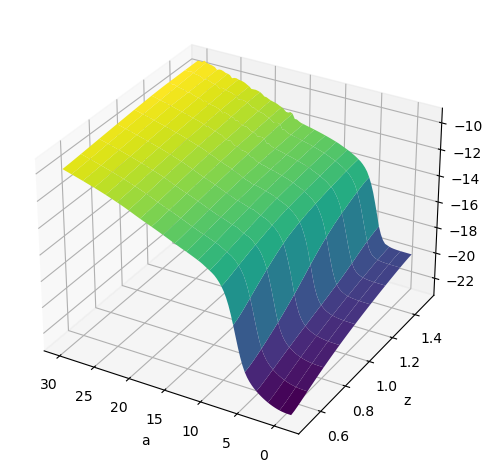

In [ ]:
fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax = fig1.add_subplot(111, projection='3d')
A_plot,Z_plot = np.meshgrid(a, z)
ax.invert_xaxis()
surface = ax.plot_surface(A_plot, Z_plot, v.T, cmap='viridis', rstride=5, cstride=5, alpha=1, antialiased=True)
ax.set_xlabel('a')
ax.set_ylabel('z')